In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



KeyboardInterrupt: 

In [ ]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

In [ ]:
path = "data/weather/"
model_path = path + 'models/'

In [ ]:
batch_size=32

# Read in the data

We set the data's index to be the timestamp, then we calculate a rolling minimum over 18h windows.  We then shift those rolling averages back by 18 hours (since Pandas can only calculate backward-facing rolling windows so we just time shift to get forward-facing windows)

In [ ]:
data = pd.read_csv(path+'forecast-current-2017-07-25-15-13-45.csv', dtype={'time':'int', 'forecast': 'float', 'current': 'float'})
data = data.assign(timestamp = pd.to_datetime(data.time, unit='s')).set_index('timestamp').tz_localize('UTC').tz_convert('US/Pacific')
data = data.assign(day_of_year = data.index.dayofyear, hour = data.index.hour)
rolling_minimums = data.rolling('18h', closed='both').current.min().shift(-18,'1h')
data = data.assign(forward_min = rolling_minimums.asof(data.index))
data.head()

In [ ]:
inputs_scaler = MinMaxScaler()
data[['forecast','current','day_of_year','hour']] = inputs_scaler.fit_transform(data[['forecast','current','day_of_year','hour']])
# outputs_scaler = MinMaxScaler()
# data[['forward_min']] = outputs_scaler.fit_transform(data[['forward_min']])
data.head()

In [ ]:
train_size = int(len(data) * 0.8)
training_data = data[:train_size]
validation_data = data[train_size:]

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :-1]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

In [ ]:
seq_length=24

In [ ]:
train_x, train_y = create_dataset(training_data[['day_of_year', 'hour', 'current', 'forecast', 'forward_min']].values, seq_length)
val_x, val_y = create_dataset(validation_data[['day_of_year', 'hour', 'current', 'forecast', 'forward_min']].values, seq_length)

In [ ]:
train_x.shape, val_x.shape

# Modeling

## First a basic LSTM

In [ ]:
def loss_fn(y_true, y_pred):
    diff = y_true - y_pred
    out = K.square(diff) - K.sign(diff)
    return K.mean(out, axis=-1)

model = Sequential([
    LSTM(1024, input_shape=(seq_length, 4), implementation=2),
    BatchNormalization(),
    
    Dense(1),
    GaussianNoise(0.5),
])
model.compile(Nadam(), loss=loss_fn)
model.summary()

In [530]:
model.fit(train_x, train_y, epochs=10, batch_size=batch_size,
           validation_data=(val_x, val_y))

Train on 3842 samples, validate on 958 samples
Epoch 1/10
3842/3842 [==============================] - 1s - loss: 29.4438 - val_loss: 39.4801
Epoch 2/10
3842/3842 [==============================] - 1s - loss: 28.7289 - val_loss: 33.0735
Epoch 3/10
3842/3842 [==============================] - 1s - loss: 29.0646 - val_loss: 33.2597
Epoch 4/10
3842/3842 [==============================] - 1s - loss: 28.7569 - val_loss: 37.2246
Epoch 5/10
3842/3842 [==============================] - 1s - loss: 28.7417 - val_loss: 35.2444
Epoch 6/10
3842/3842 [==============================] - 1s - loss: 28.6081 - val_loss: 36.7860
Epoch 7/10
3842/3842 [==============================] - 1s - loss: 28.6879 - val_loss: 35.5961
Epoch 8/10
3842/3842 [==============================] - 1s - loss: 28.7598 - val_loss: 36.5182
Epoch 9/10
3842/3842 [==============================] - 1s - loss: 28.3647 - val_loss: 37.2152
Epoch 10/10
3842/3842 [==============================] - 1s - loss: 28.5872 - val_loss: 34.5836


In [528]:
model.optimizer.lr.set_value(model.optimizer.get_config()['lr']/10)

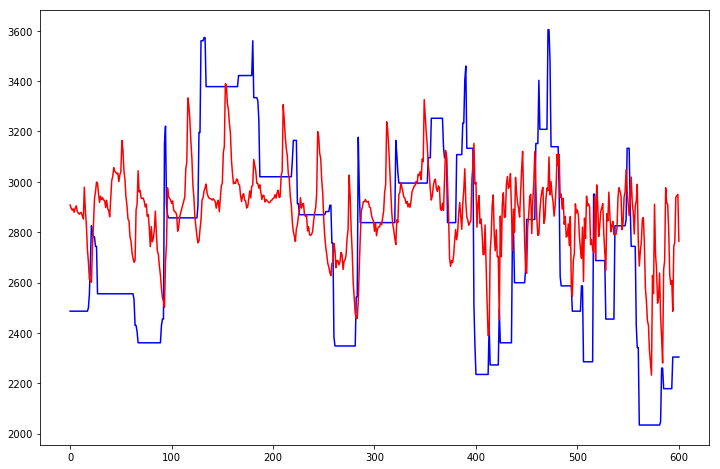

In [531]:
mar = data['2016-02':'2016-03']
plot_ds_x, plot_ds_y = create_dataset(mar[['day_of_year', 'hour', 'current', 'forecast', 'forward_min']].values, seq_length)
plt.figure(figsize=(12,8))
plt.plot(outputs_scaler.inverse_transform(plot_ds_y.reshape(-1,1)), 'b')
plt.plot(outputs_scaler.inverse_transform(model.predict(plot_ds_x)), 'r')

## Now CNN

In [ ]:
def loss_fn(y_true, y_pred):
    diff = y_true - y_pred
#    out = K.square(diff) - K.exp(32 - y_true)
    out = K.square(diff)*(K.sign(diff)+1) + 3*K.square(diff)*(K.sign(-diff)+1)
    return K.mean(out, axis=-1)

model = Sequential([
    Conv1D(64, 2, activation='relu', input_shape=(seq_length, 4)),
    BatchNormalization(),
    Conv1D(64, 2, activation='relu'),
    BatchNormalization(),

    MaxPooling1D(),

    Conv1D(64, 2, activation='relu'),
    BatchNormalization(),
    Conv1D(64, 2, activation='relu'),
    BatchNormalization(),

    MaxPooling1D(),

    Conv1D(64, 2, activation='relu'),
    BatchNormalization(),
    Conv1D(64, 2, activation='relu'),
    BatchNormalization(),

    MaxPooling1D(),

    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    
    Dropout(0.75),
    Dense(1),
])
model.compile(Nadam(), loss=loss_fn)
model.summary()

In [62]:
model.fit(train_x, train_y, epochs=8, batch_size=batch_size,
           validation_data=(val_x, val_y))

Train on 3821 samples, validate on 937 samples
Epoch 1/8
3821/3821 [==============================] - 2s - loss: 202.0465 - val_loss: 120.0499
Epoch 2/8
3821/3821 [==============================] - 2s - loss: 183.6611 - val_loss: 117.0560
Epoch 3/8
3821/3821 [==============================] - 2s - loss: 192.3132 - val_loss: 115.6801
Epoch 4/8
3821/3821 [==============================] - 2s - loss: 196.9432 - val_loss: 114.0400
Epoch 5/8
3821/3821 [==============================] - 2s - loss: 188.9873 - val_loss: 114.2118
Epoch 6/8
3821/3821 [==============================] - 2s - loss: 189.3039 - val_loss: 113.0524
Epoch 7/8
3821/3821 [==============================] - 2s - loss: 190.6972 - val_loss: 111.9929
Epoch 8/8
3821/3821 [==============================] - 2s - loss: 188.5351 - val_loss: 112.6481


In [61]:
model.optimizer.lr.set_value(model.optimizer.get_config()['lr']/10)

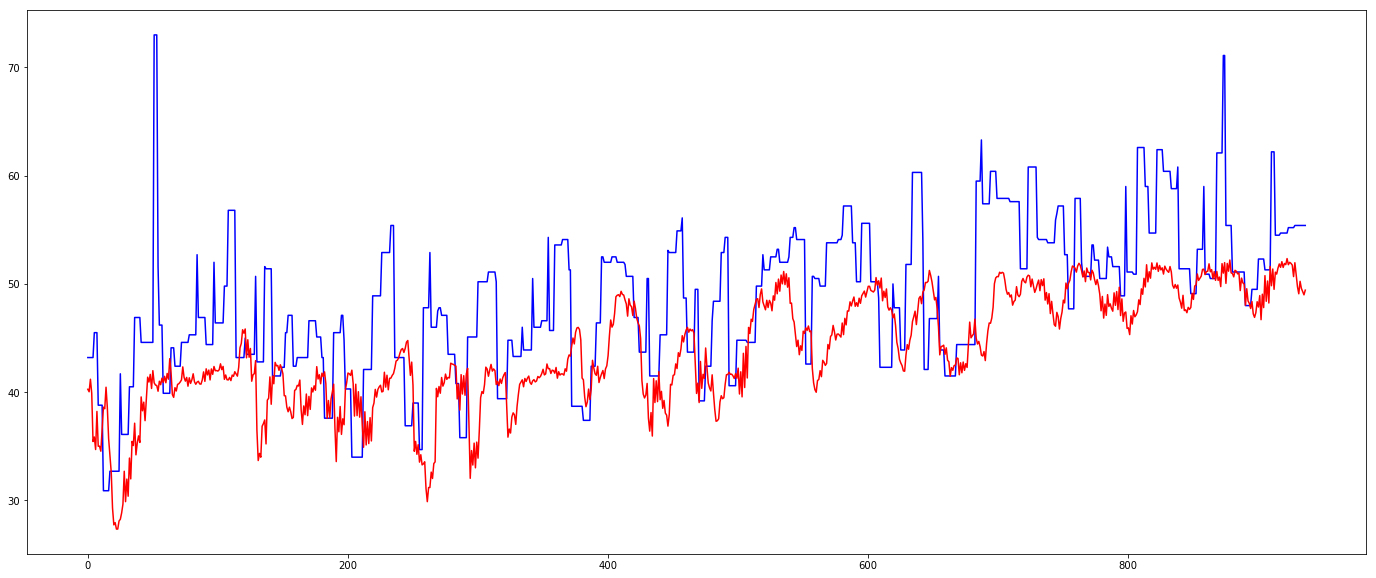

In [64]:
mar = validation_data
plot_ds_x, plot_ds_y = create_dataset(mar[['day_of_year', 'hour', 'current', 'forecast', 'forward_min']].values, seq_length)
plt.figure(figsize=(24,10))
# plt.plot(inputs_scaler.inverse_transform(mar[['forecast', 'current', 'day_of_year', 'hour']])[:,0], 'g')
plt.plot(plot_ds_y, 'b')
plt.plot(model.predict(plot_ds_x), 'r')
plt.show()